In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc

In [2]:
X, y = make_classification(n_samples = 100, n_features = 50)
X = np.reshape(X, [X.shape[0], X.shape[1], 1])

print(f"X: {X.shape} - y: {y.shape}")

X: (100, 50, 1) - y: (100,)


In [3]:
seed = 0
tf.random.set_random_seed(seed)
np.random.seed(seed)

#####################################
####### DEFINING LSTM MODEL #########
#####################################

length = X.shape[1]
n_features = X.shape[-1]
n_classes = to_categorical(y).shape[-1]

model_lstm = Sequential()

model_lstm.add(LSTM(units = 100, 
              input_shape = (length, n_features), return_sequences = False))
model_lstm.add(Dense(n_classes, activation = "softmax"))

model_lstm.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model_lstm.summary()

#####################################
######## DEFINING GRU MODEL #########
#####################################

seed = 0
tf.random.set_random_seed(seed)
np.random.seed(seed)

model_gru = Sequential()

model_gru.add(GRU(units = 100, 
              input_shape = (length, n_features), return_sequences = False))
model_gru.add(Dense(n_classes, activation = "softmax"))

model_gru.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model_gru.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100)               30600     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 30,802
Trainable params: 30,802
Non-trainable params: 0
___________

In [4]:
model_name = 'lstm'
n_folds = 5

cv = StratifiedKFold(n_splits = 5)
seed = 0
tf.random.set_random_seed(seed)
np.random.seed(seed)

auroc_per_fold = []

df_roc_curve = pd.DataFrame(columns = range(1, n_folds))

# Array to compute the mean false positive rate (100 points)
mean_fpr = np.linspace(0, 1, 100)

for n_fold, (train, test) in enumerate(cv.split(X, y)):
    
    hist = model_lstm.fit(X[train],
                   to_categorical(y[train]),
                   epochs = 1,
                   batch_size = 100)
    
    y_logits = model_lstm.predict(X[test])

    # Computing scores for the positive class only (taking position '1' as the positive class)
    y_scores = y_logits[:,1]
    _fpr, _tpr, _ = roc_curve(y[test], y_scores)
    
    # Calculating the tpr in exact 100 points using linear interpolation
    interp_tpr = np.interp(mean_fpr, _fpr, _tpr)
    interp_tpr[0] = 0.0
    
    # Saving fpr and tpr per fold
    df_roc_curve[n_fold + 1] = interp_tpr
    
    # AUC score
    auroc_score = auc(_fpr, _tpr)
    auroc_per_fold.append(auroc_score)
    
# Computing standard deviation
std_dev_tpr = df_roc_curve.std(axis = 1)
# Computing and adding mean into the dataframe
df_roc_curve['mean_tpr'] = df_roc_curve.mean(axis = 1)
# Adding standard deviation
df_roc_curve['std_tpr'] = std_dev_tpr
# Adding fpr to the dataframe
df_roc_curve['fpr'] = mean_fpr

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 80 samples
80/80 [==============================] - 1s 8ms/sample - loss: 0.7001 - acc: 0.4625
Train on 80 samples
80/80 [==============================] - 0s 524us/sample - loss: 0.6933 - acc: 0.5125
Train on 80 samples
80/80 [==============================] - 0s 560us/sample - loss: 0.6928 - acc: 0.4875
Train on 80 samples
80/80 [==============================] - 0s 603us/sample - loss: 0.6887 - acc: 0.5000
Train on 80 samples
80/80 [==============================] - 0s 579us/sample - loss: 0.6889 - acc: 0.4500


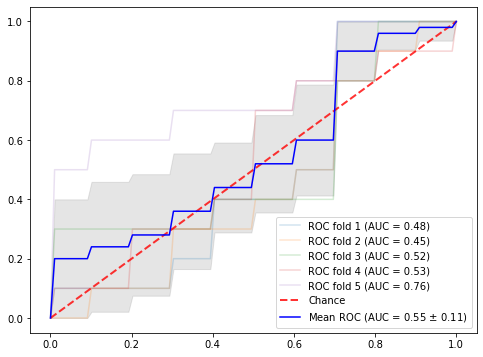

In [5]:
mean_auc = auc(df_roc_curve['fpr'], df_roc_curve['mean_tpr'])
std_auc = np.std(auroc_per_fold)

fig, axes = plt.subplots(figsize = (8, 6))

for fold in range(1, 6):
    auc_score = auroc_per_fold[fold - 1]
    axes.plot(df_roc_curve['fpr'], df_roc_curve[fold], label = f'ROC fold {fold} (AUC = {auc_score:.2f})', alpha = .2)

# Plotting chance curve
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Chance', alpha = .8)
# Plotting mean curve
axes.plot(df_roc_curve['fpr'], df_roc_curve['mean_tpr'], color = 'blue', label = f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})')

tpr_upper = np.minimum(df_roc_curve['mean_tpr'] + df_roc_curve['std_tpr'], 1)
tpr_lower = np.maximum(df_roc_curve['mean_tpr'] - df_roc_curve['std_tpr'], 0)

axes.fill_between(df_roc_curve['fpr'], tpr_lower, tpr_upper, color = 'grey', alpha = .2)

axes.legend()